In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '../data/decesion-tree/风机结冰预测/train'
machine = '15' # or '21'
train_path = path + f'/{machine}'

In [3]:
train_data_raw = pd.read_csv(f'{train_path}/{machine}_data.csv')
train_failInfo = pd.read_csv(f'{train_path}/{machine}_failureInfo.csv')
train_normInfo = pd.read_csv(f'{train_path}/{machine}_normalInfo.csv')
print(f'total: {len(train_data_raw)}')
print(f'fail num: {len(train_failInfo)}, norm num: {len(train_normInfo)}')

total: 393886
fail num: 29, norm num: 26


In [4]:
# train_data_raw.head()
train_failInfo.head(), train_normInfo.head()

(          startTime           endTime
 0   2015/11/4 21:37   2015/11/4 22:29
 1    2015/11/9 4:43    2015/11/9 6:35
 2   2015/11/9 21:21   2015/11/9 23:14
 3   2015/11/16 3:51  2015/11/16 11:06
 4  2015/11/16 14:15  2015/11/16 16:08,
              startTime              endTime
 0  2015-11-01 20:20:16  2015-11-03 23:47:32
 1  2015-11-04 14:04:51  2015-11-04 18:26:08
 2  2015-11-05 11:06:59  2015-11-09 02:44:31
 3  2015-11-09 12:30:09  2015-11-09 19:23:32
 4  2015-11-10 00:04:50  2015-11-15 23:03:06)

In [5]:
train_data_raw.time = pd.to_datetime(train_data_raw.time)
train_failInfo.startTime = pd.to_datetime(train_failInfo.startTime)
train_failInfo.endTime = pd.to_datetime(train_failInfo.endTime)
train_normInfo.startTime = pd.to_datetime(train_normInfo.startTime)
train_normInfo.endTime = pd.to_datetime(train_normInfo.endTime)

In [6]:
train_failInfo.head()
train_normInfo.head()

,startTime,endTime
0,2015-11-01 20:20:16,2015-11-03 23:47:32
1,2015-11-04 14:04:51,2015-11-04 18:26:08
2,2015-11-05 11:06:59,2015-11-09 02:44:31
3,2015-11-09 12:30:09,2015-11-09 19:23:32
4,2015-11-10 00:04:50,2015-11-15 23:03:06


In [7]:
def select_fail_norm(X: pd.DataFrame, failInfo: pd.DataFrame, normInfo: pd.DataFrame):
    fail_df = pd.DataFrame(columns=X.columns)
    for i in range(len(failInfo)):
        f = failInfo.iloc[i, :]
        temp = X[(X.time >= f.startTime) & (X.time <= f.endTime)]
        fail_df = pd.concat([fail_df, temp])

    norm_df = pd.DataFrame(columns=X.columns)
    for i in range(len(normInfo)):
        n = normInfo.iloc[i, :]
        temp = X[(X.time >= n.startTime) & (X.time <= n.endTime)]
        norm_df = pd.concat([norm_df, temp])
    fail_df['state'] = 1
    norm_df['state'] = 0
    return fail_df, norm_df

In [8]:
train_fail_raw, train_norm_raw = select_fail_norm(train_data_raw, train_failInfo, train_normInfo)
print(f'total: {len(train_data_raw)}')
print(f'fail num: {len(train_fail_raw)}, norm num: {len(train_norm_raw)}, invalid={len(train_data_raw) - len(train_fail_raw) - len(train_norm_raw)}')

total: 393886
fail num: 23846, norm num: 350255, invalid=19785


In [9]:
train_fail_raw.head()
train_norm_raw.head()

,time,wind_speed,generator_speed,power,wind_direction,wind_direction_mean,yaw_position,yaw_speed,pitch1_angle,pitch2_angle,...,environment_tmp,int_tmp,pitch1_ng5_tmp,pitch2_ng5_tmp,pitch3_ng5_tmp,pitch1_ng5_DC,pitch2_ng5_DC,pitch3_ng5_DC,group,state
0,2015-11-01 20:20:16,1.859993,1.223595,2.51579,-2.072739,-2.073627,-0.655343,0.030804,0.555556,0.506667,...,-0.403919,0.014918,1.307692,1.123077,0.783077,1.36,0.0,1.56,1,0
1,2015-11-01 20:20:23,1.911625,1.293394,2.313551,-2.010591,-1.61514,-0.655343,0.030804,0.195556,0.133333,...,-0.421277,-0.002291,1.307692,1.123077,0.783077,0.44,2.88,-2.6,1,0
2,2015-11-01 20:20:30,1.635027,1.280099,2.507799,-2.05375,-0.282742,-0.649566,0.170338,0.964444,0.951111,...,-0.421277,-0.002291,1.307692,1.123077,0.783077,1.76,0.6,2.56,1,0
3,2015-11-01 20:20:37,1.786234,1.280099,2.349593,-2.007138,-2.234477,-0.655343,-0.00408,0.168889,0.137778,...,-0.403919,-0.002291,1.307692,1.123077,0.783077,2.8,-0.48,0.12,1,0
4,2015-11-01 20:20:47,1.786234,1.26348,2.321566,-2.264365,-1.428959,-0.637917,0.414524,0.182222,0.168889,...,-0.403919,0.014918,1.307692,1.123077,0.783077,-0.88,1.72,0.92,1,0


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
def split_train_val(X):
    x_train, x_val = train_test_split(X, test_size=0.3, shuffle=True)
    return x_train, x_val

In [11]:
train_fail_raw_train, train_fail_raw_val = split_train_val(train_fail_raw)
train_norm_raw_train, train_norm_raw_val = split_train_val(train_norm_raw)

In [12]:
from sklearn.utils import shuffle
data_raw_train = shuffle(pd.concat([train_fail_raw_train, train_norm_raw_train]))
data_raw_val = shuffle(pd.concat([train_fail_raw_val, train_norm_raw_val]))

In [49]:
from sklearn.tree import DecisionTreeClassifier
baseline_model = DecisionTreeClassifier()
baseline_model.fit(data_raw_train.iloc[:, 1:-2], data_raw_train.iloc[:, -1])
score = cross_val_score(baseline_model, data_raw_val.iloc[:, 1:-2], data_raw_val.iloc[:, -1]).mean()
score

0.9979862968352581

In [43]:
from sklearn.feature_selection import RFECV
model = DecisionTreeClassifier()
X = data_raw_train.iloc[:, 1:-2].copy()
y = data_raw_train.iloc[:, -1].copy()
selector = RFECV(model, step=1, cv=5)
selector = selector.fit(X, y)
selector.support_

array([ True, False,  True, False, False,  True, False,  True,  True,
        True, False, False, False,  True,  True,  True, False, False,
        True,  True, False, False, False, False, False, False])

In [46]:
cols = np.array(list(X.columns))[selector.support_].tolist()
X_train_selected = X[cols]
X_train_selected.head()

,wind_speed,power,yaw_position,pitch1_angle,pitch2_angle,pitch3_angle,pitch1_moto_tmp,pitch2_moto_tmp,pitch3_moto_tmp,environment_tmp,int_tmp
88468,0.104521,-0.28869,-0.428338,0.355556,0.36,0.337778,-0.9,-0.91,-0.869,0.004799,0.284538
122329,-0.113069,-0.102458,-0.277001,0.328889,0.32,0.337778,-0.68,-0.669,-0.659,0.636024,0.91365
187814,-0.684703,-0.603085,-0.370142,0.333333,0.32,0.36,-0.969,-0.95,-0.95,0.036361,0.014918
347868,2.922128,2.487762,-0.61462,4.577778,4.546667,4.568889,1.519,1.11,1.16,-1.289211,-1.514838
370753,-0.415482,-0.438881,-0.824152,0.217778,0.208889,0.208889,-1.889,-1.92,-1.879,-1.951997,-2.088497


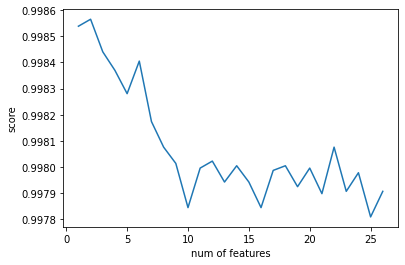

In [47]:
scores = []
def select_best_feats(selector):
    for i in range(len(X.columns)):
        model = DecisionTreeClassifier()
        cols = np.array(list(X.columns))[selector.ranking_<=i+1].tolist()
        X_train_selected = X[cols]
        model.fit(X_train_selected, y)
        X_val_selected = data_raw_val.iloc[:, 1:-2].copy()[cols]
        y_val = data_raw_val.iloc[:, -1].copy()
        score = cross_val_score(model, X_val_selected, y_val).mean()
        scores.append(score)
    plt.plot(np.arange(len(X.columns))+1, scores)
    plt.xlabel('num of features')
    plt.ylabel('score')
    plt.show()
    return np.argmax(scores)+1
best_feats = select_best_feats(selector)

In [80]:
cols = np.array(list(X.columns))[selector.support_].tolist()
X_train_selected = X[cols]
model = DecisionTreeClassifier()
model.fit(X_train_selected, y)
X_val_selected = data_raw_val.iloc[:, 1:-1].copy()[cols]
y_val = data_raw_val.iloc[:, -1].copy()
score = cross_val_score(model, X_val_selected, y_val).mean()
score

0.9986545590152719

In [78]:
X_val_selected = data_raw_val.iloc[:, 1:-1].copy()[cols]
y_val = data_raw_val.iloc[:, -1].copy()
# X_train_selected['wp_ratio'] = X_train_selected.wind_speed / X_train_selected.power
# X_train_selected['wg_ratio'] = X_train_selected.wind_speed / data_raw_train.generator_speed
# X_val_selected['wp_ratio'] = X_val_selected.wind_speed / X_val_selected.power
# X_val_selected['wg_ratio'] = X_val_selected.wind_speed / data_raw_val.generator_speed
model = DecisionTreeClassifier()
model.fit(X_train_selected, y)
score = cross_val_score(model, X_val_selected, y_val).mean()
score

0.9986456495356208

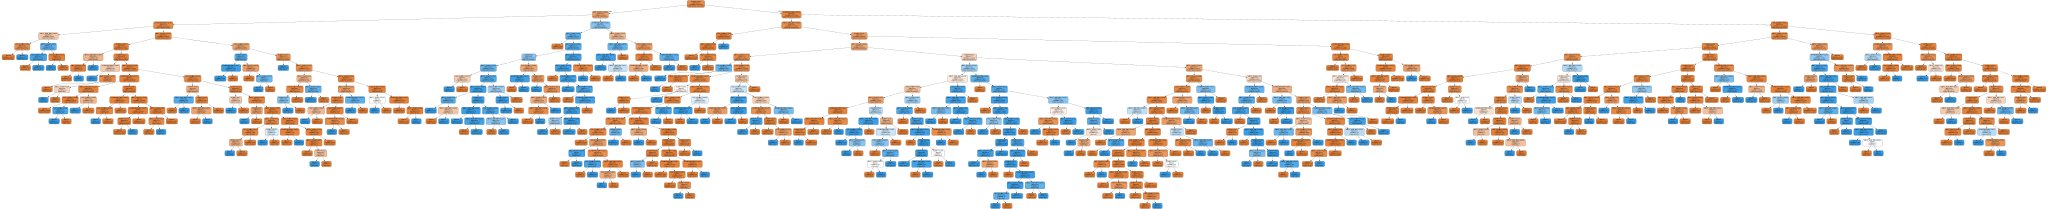

<Figure size 1440x1440 with 0 Axes>

In [82]:
import graphviz
from sklearn import tree
feat_names = list(X_train_selected.columns)
# class_names = ['Norm', 'Fail']
plt.figure(figsize=(20, 20))
graph = tree.export_graphviz(model, filled=True, rounded=True, feature_names=feat_names)
graph =graphviz.Source(graph)
graph

In [71]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    cf_matrix = confusion_matrix(y_true, y_pred)
    pred_score = precision_score(y_true, y_pred)
    pred_recall = recall_score(y_true, y_pred)
    return cf_matrix, (pred_score, pred_recall)

(0.9945591517857143, 0.9965054514956667)


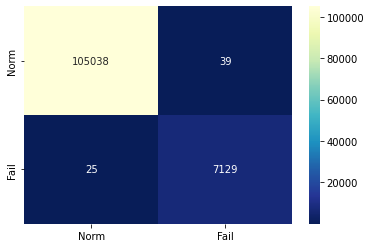

In [81]:
class_names = ['Norm', 'Fail']
cf_matrix, pred_score = evaluate(model, X_val_selected, y_val)
sns.heatmap(pd.DataFrame(cf_matrix, columns=class_names, index=class_names), cmap="YlGnBu_r", fmt="d", annot=True)
print(pred_score)